#### If you haven't installed Hummingbird or matplotlib, do that first

In [ ]:
#! pip install hummingbird_ml matplotlib

#### Import necessary libraries

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from hummingbird.ml import convert

#### Create and fit the model

In [3]:
# Create and train a RandomForestClassifier model
X, y = load_breast_cancer(return_X_y=True)
skl_model = RandomForestClassifier(n_estimators=500, max_depth=7)
skl_model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Time scikit-learn

In [4]:
skl_time = %timeit -o skl_model.predict(X)

49.9 ms ± 293 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Convert SKL model to PyTorch

In [5]:
model = convert(skl_model, 'torch')

#### Time PyTorch - CPU

In [6]:
pred_cpu_hb = %timeit -o model.predict(X)

9.14 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Switch PyTorch from CPU to GPU

In [7]:
%%capture 
model.to('cuda')

#### Time PyTorch - GPU

In [8]:
pred_gpu_hb = %timeit -o model.predict(X)

1.21 ms ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Convert SKL model to TVM (CPU)

In [9]:
model_tvm = convert(skl_model, 'tvm', X)

#### Time TVM - CPU

In [10]:
pred_cpu_tvm = %timeit -o model_tvm.predict(X)

3.95 ms ± 77.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Convert SKL model to TVM (GPU)

In [11]:
model_tvm = convert(skl_model, 'tvm', X, 'cuda')

#### Time TVM - GPU

In [12]:
pred_gpu_tvm = %timeit -o model_tvm.predict(X)

493 µs ± 2.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Plot the results

In [17]:
def plot(title, skl_time, pred_cpu_hb, pred_gpu_hb, pred_cpu_tvm, pred_gpu_tvm):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.pyplot import cm

    fig = plt.figure()

    x = ['skl','pyt-cpu','pyt-gpu','tvm-cpu','tvm-gpu']
    height = [skl_time.average,pred_cpu_hb.average,pred_gpu_hb.average,pred_cpu_tvm.average,pred_gpu_tvm.average]
    width = 1.0
    plt.ylabel('time in seconds')
    plt.xlabel(title)

    rects = plt.bar(x, height, width, color=cm.rainbow(np.linspace(0,1,5)))
    def autolabel(rects):

        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%.4f' % (height),
                    ha='center', va='bottom')

    autolabel(rects)
    plt.show()

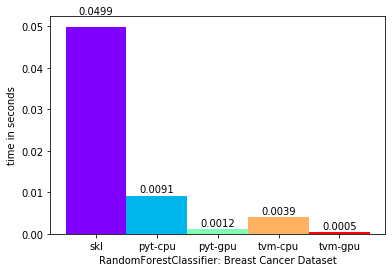

In [16]:
plot("RandomForestClassifier: Breast Cancer Dataset",skl_time, pred_cpu_hb, pred_gpu_hb, pred_cpu_tvm, pred_gpu_tvm)